In [19]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from math import sqrt

In [2]:
# 1/1/18-9/31-19 split to 16 months train 5 months test

train_src = pd.read_csv("train_bank_df.csv")
test_src  = pd.read_csv("test_bank_df.csv")

# Remove rows w/ 'credit' and 'credit card payment' to avoid double charges
test_df  = test_src[~((test_src['Transaction Type'] == 'credit') & 
                      (test_src['Category'] == 'Credit Card Payment'))]

train_df  = train_src[~((train_src['Transaction Type'] == 'credit') & 
                        (train_src['Category'] == 'Credit Card Payment'))]

In [3]:
train_df = train_df.dropna(axis=0)
train_df

,Date,Description,Amount,Transaction Type,Category,Account Name
0,1/1/18,Amazon,11.11,debit,Shopping,Platinum Card
1,1/2/18,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking
2,1/2/18,Thai Restaurant,24.22,debit,Restaurants,Silver Card
4,1/4/18,Netflix,11.76,debit,Movies & DVDs,Platinum Card
5,1/5/18,American Tavern,25.85,debit,Restaurants,Silver Card
...,...,...,...,...,...,...
611,4/27/19,Brewing Company,40.00,debit,Alcohol & Bars,Platinum Card
613,4/27/19,American Tavern,14.74,debit,Restaurants,Silver Card
614,4/29/19,Credit Card Payment,268.96,debit,Credit Card Payment,Checking
615,4/29/19,Grocery Store,5.64,debit,Groceries,Platinum Card


In [4]:
test_df = test_df.dropna(axis=0)
test_df

,Date,Description,Amount,Transaction Type,Category,Account Name
0,5/1/19,Amazon,13.09,debit,Shopping,Platinum Card
1,5/2/19,Mortgage Payment,1100.00,debit,Mortgage & Rent,Checking
2,5/3/19,Credit Card Payment,758.07,debit,Credit Card Payment,Checking
3,5/4/19,Netflix,13.90,debit,Television,Platinum Card
4,5/6/19,Amazon,16.94,debit,Shopping,Platinum Card
...,...,...,...,...,...,...
184,9/27/19,Biweekly Paycheck,2250.00,credit,Paycheck,Checking
185,9/28/19,BP,33.46,debit,Gas & Fuel,Platinum Card
186,9/28/19,Sheetz,4.27,debit,Gas & Fuel,Platinum Card
187,9/30/19,Starbucks,1.75,debit,Coffee Shops,Platinum Card


In [5]:
#  Convert 'Date' to datetime format to index. Group data by month and sum the amounts per category
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)
monthly_train_data = train_df.groupby(['Category', pd.Grouper(freq='M')])['Amount'].sum().unstack()

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)
monthly_test_data = test_df.groupby(['Category', pd.Grouper(freq='M')])['Amount'].sum().unstack()

/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1630688696.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['Date'] = pd.to_datetime(train_df['Date'])
/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1630688696.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_df['Date'] = pd.to_datetime(test_df['Date'])


In [18]:
monthly_train_data.fillna(0, inplace=True)
monthly_train_data.to_csv("monthly-train-all.csv")

monthly_train_data

Date,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30
Category,,,,,,,,,,,,,,,,
Alcohol & Bars,0.00,14.00,19.50,0.00,27.77,0.00,35.14,0.00,65.40,12.71,86.60,26.00,0.00,8.00,49.63,54.40
Auto Insurance,0.00,0.00,0.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00
Coffee Shops,3.00,6.00,10.00,7.00,0.00,10.50,0.00,0.00,5.00,3.00,0.00,6.00,0.00,6.00,18.04,0.00
Credit Card Payment,864.80,1075.61,1321.50,3166.88,884.47,1550.83,666.34,403.50,972.25,605.98,845.50,775.05,3450.88,1208.80,1098.92,2862.68
Electronics & Software,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,320.99,44.93
Entertainment,0.00,0.00,0.00,0.00,9.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fast Food,32.91,10.66,23.34,0.00,27.79,61.50,24.81,13.67,0.00,0.00,37.85,98.10,0.00,0.00,0.00,0.00
Food & Dining,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.75,0.00,63.00,0.00,0.00,0.00,0.00
Gas & Fuel,65.29,68.68,65.45,81.56,72.74,77.15,137.90,150.82,117.57,72.72,65.66,120.37,60.24,57.81,71.59,78.02


In [17]:
monthly_test_data.fillna(0, inplace=True)

'''
train_categories = set(monthly_train_data.index)
test_categories = set(monthly_test_data.index)

print(train_categories)
print(test_categories)

# Find the missing categories in testing data
missing_categories = train_categories - test_categories

# Add missing categories to testing data with 0 values
for category in missing_categories:
    print(category)
    monthly_test_data.loc[category] = 0

# Sort the testing data based on the index (categories)
monthly_test_data.sort_index(inplace=True)
'''

monthly_test_data.to_csv("monthly-testr-all.csv")
monthly_test_data

Date,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30
Category,,,,,
Alcohol & Bars,0.00,30.00,19.00,18.00,72.98
Auto Insurance,75.00,75.00,75.00,75.00,75.00
Coffee Shops,0.00,6.50,9.50,14.00,11.00
Credit Card Payment,2420.10,1087.22,1596.94,2222.97,3960.14
Electronics & Software,353.08,0.00,0.00,0.00,0.00
Entertainment,0.00,0.00,0.00,0.00,0.00
Fast Food,0.00,0.00,0.00,0.00,0.00
Food & Dining,0.00,0.00,0.00,0.00,0.00
Gas & Fuel,72.00,105.63,36.42,71.05,66.50


In [108]:
category_options = monthly_train_data.index
rmse_log = []

category_model_dict = []

# Loop through each category
for category in category_options:

    train_data = monthly_train_data.loc[category]
    test_data = monthly_test_data.loc[category]
    
    # Train an ARIMA model
    model = ARIMA(train_data, order=(4, 1, 0))
    model_fit = model.fit()

    category_model_dict.append([category, model])

    # Make predictions
    predictions = model_fit.forecast(steps=len(test_data))

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test_data, predictions))
    # print(f'Root Mean Squared Error for {category}: {rmse}')

    rmse_log.append([category, rmse])

    # Plot the results
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data.values, label=f'Actual - {category}')
    plt.plot(test_data.index, predictions.values, label=f'Predicted - {category}')
    plt.title(f'Actual vs Predicted for {category}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    '''

print(rmse_log)

[['Alcohol & Bars', 23.59516563644364], ['Auto Insurance', 0.0], ['Coffee Shops', 6.63443592938269], ['Credit Card Payment', 1094.376022617732], ['Electronics & Software', 147.4326845641498], ['Entertainment', 3.248727419079571e-30], ['Fast Food', 33.95681916013975], ['Food & Dining', 12.253434396199905], ['Gas & Fuel', 22.897369633274693], ['Groceries', 133.75582092704082], ['Haircut', 14.3563284305842], ['Home Improvement', 4104.077092409235], ['Internet', 0.006126606718240117], ['Mobile Phone', 0.4958060147171224], ['Mortgage & Rent', 0.011101466568306472], ['Movies & DVDs', 0.08538204066007683], ['Music', 0.0], ['Paycheck', 800.2857749682055], ['Restaurants', 98.65026820254859], ['Shopping', 39.844315615666744], ['Television', 2.1398808680138885], ['Utilities', 13.002833539998267]]


/Users/aniket/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aniket/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aniket/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
'''
# Hyperparameter Tuning
from itertools import product

p_values = range(0, 5)  # Adjust as needed
d_values = range(0, 3)  # Adjust as needed
q_values = range(0, 2)  # Adjust as needed

best_rmse = float('inf')
best_params = None

for category in category_options:
    # Filter data for the current category
    train_data = monthly_train_data.loc[category]
    test_data  = monthly_test_data.loc[category]

    # Iterate over hyperparameter combinations
    for p, d, q in product(p_values, d_values, q_values):
        try:
            # Train ARIMA model
            model = ARIMA(train_data, order=(p, d, q))
            result = model.fit()

            
            # # Make predictions on the testing set for evaluation
            # predictions = model_fit.forecast(steps=len(test_data))

            # # Calculate RMSE
            # rmse = sqrt(mean_squared_error(test_data, predictions))
            
            forecast_steps = len(test_data)
            forecast = result.get_forecast(steps=forecast_steps)

            # Adjusted range for forecast steps
            predictions = forecast.predicted_mean.iloc[:forecast_steps]
        
            # Evaluate model on the test set
            rmse = sqrt(mean_squared_error(test_data, predictions))

            # Update best parameters if current combination has lower RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'category': category, 'order': (p, d, q)}
                print(f"Best for {category} is now {p}, {d}, {q}")

        except Exception as e:
            # Handle exceptions that may occur during model training
            print(f"Error for category {category} and order ({p}, {d}, {q}): {e}")

    print(f"{category} Best hyperparameters: {best_params}, Best RMSE: {best_rmse}")
'''

In [40]:
category_options


Index(['Alcohol & Bars', 'Auto Insurance', 'Coffee Shops',
       'Credit Card Payment', 'Electronics & Software', 'Entertainment',
       'Fast Food', 'Food & Dining', 'Gas & Fuel', 'Groceries', 'Haircut',
       'Home Improvement', 'Internet', 'Mobile Phone', 'Mortgage & Rent',
       'Movies & DVDs', 'Music', 'Paycheck', 'Restaurants', 'Shopping',
       'Television', 'Utilities'],
      dtype='object', name='Category')

In [89]:
# ATTEMPTING TO USE VAR MODEL

train_t = monthly_train_data.T
test_t  = monthly_test_data.T

constant_columns = train_t.columns[train_t.nunique() == 1]
train_t_fil = train_t.drop(columns = constant_columns)
test_t_fil  = test_t.drop(columns = constant_columns)

# Train an VAR model on train data, make predictions, and evaluate the model
ts_model = VAR(train_t_fil)
model_fit = ts_model.fit()

print(train_t_fil)
print(test_t_fil)

Category    Alcohol & Bars  Auto Insurance  Coffee Shops  Credit Card Payment  \
Date                                                                            
2018-01-31            0.00             0.0          3.00               864.80   
2018-02-28           14.00             0.0          6.00              1075.61   
2018-03-31           19.50             0.0         10.00              1321.50   
2018-04-30            0.00            75.0          7.00              3166.88   
2018-05-31           27.77            75.0          0.00               884.47   
2018-06-30            0.00            75.0         10.50              1550.83   
2018-07-31           35.14            75.0          0.00               666.34   
2018-08-31            0.00            75.0          0.00               403.50   
2018-09-30           65.40            75.0          5.00               972.25   
2018-10-31           12.71            75.0          3.00               605.98   
2018-11-30           86.60  

RMSE for Alcohol & Bars: 50.80204233493967


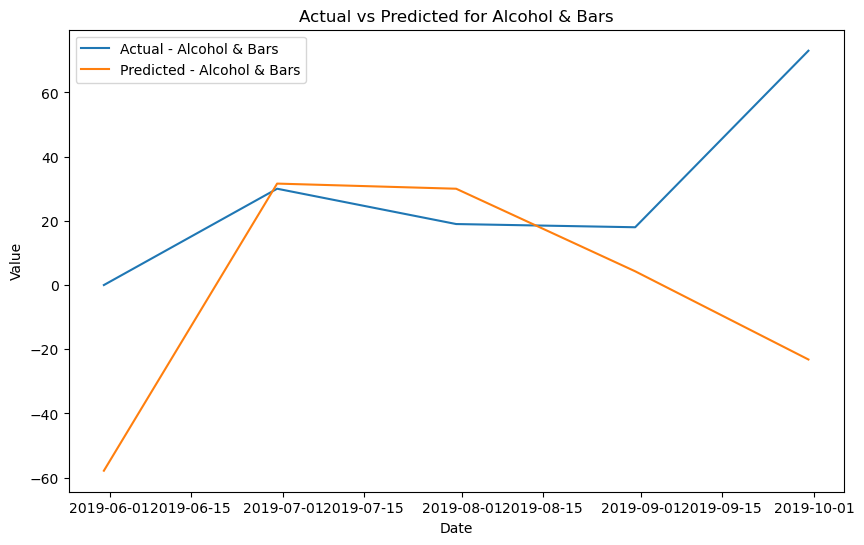

RMSE for Auto Insurance: 16.70411111799306


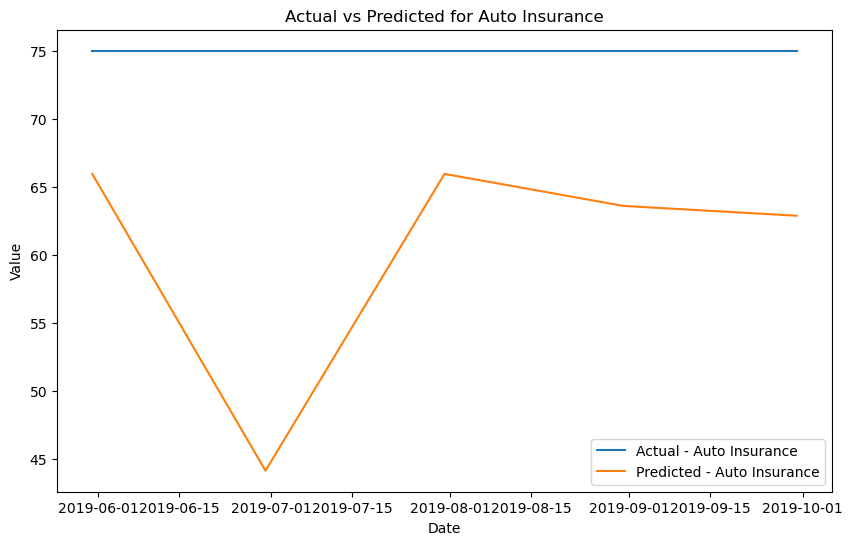

RMSE for Coffee Shops: 11.582442503386616


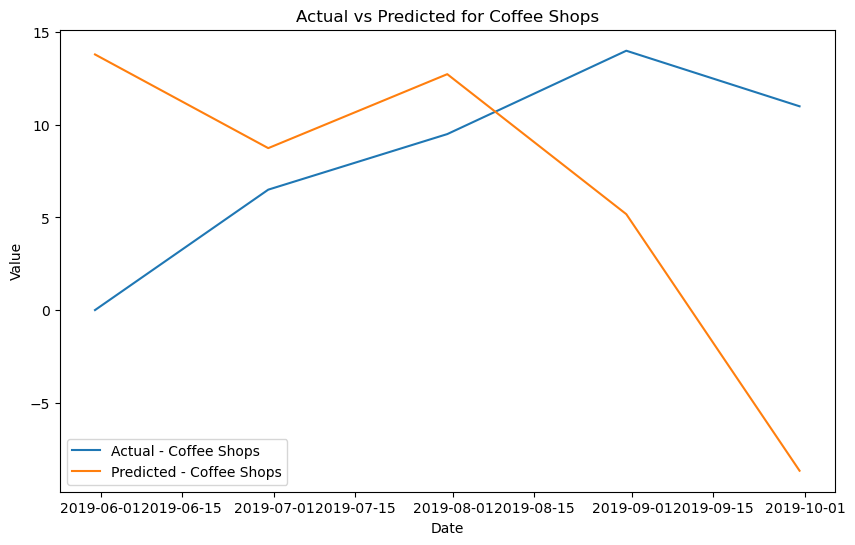

RMSE for Credit Card Payment: 1815.8713622708613


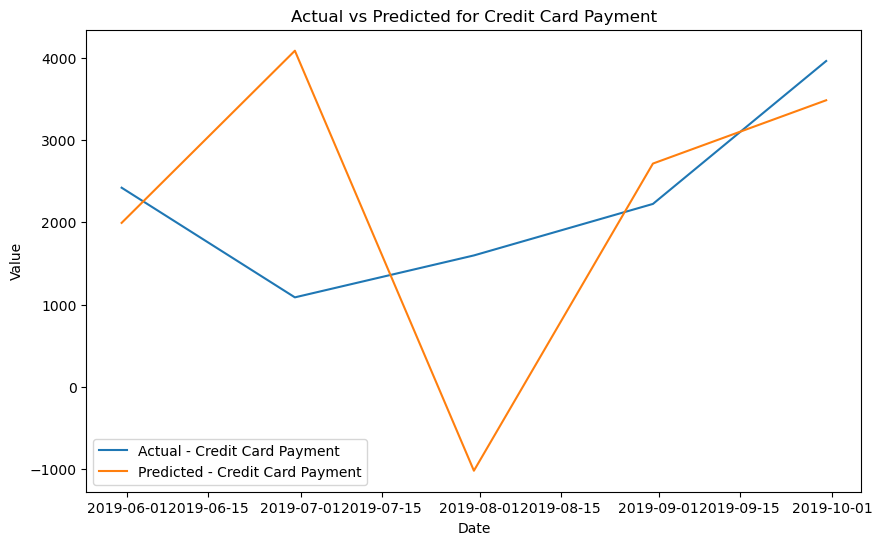

RMSE for Electronics & Software: 237.8536777340516


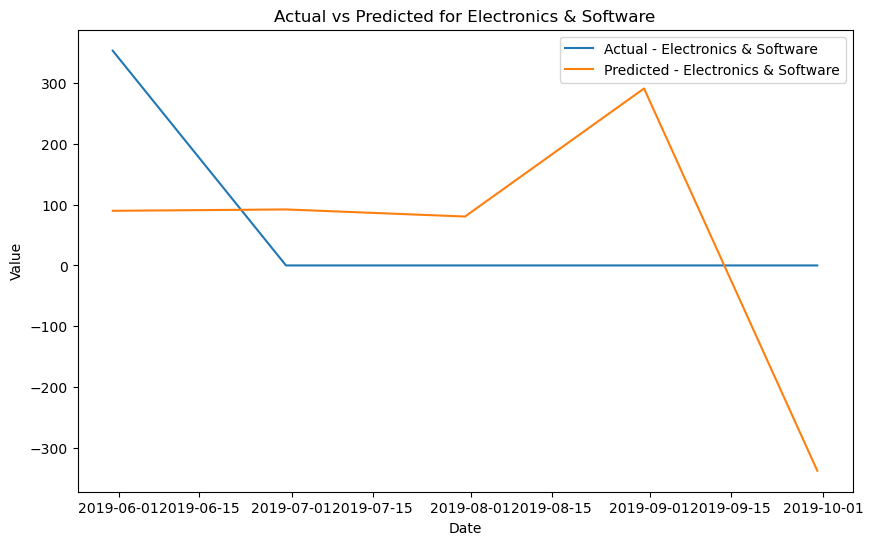

RMSE for Entertainment: 5.300188971948334


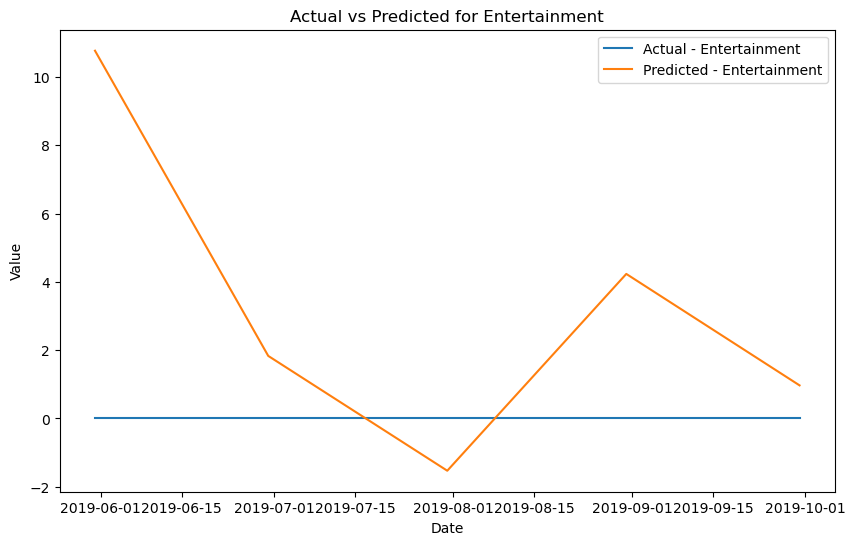

RMSE for Fast Food: 56.321753438968145


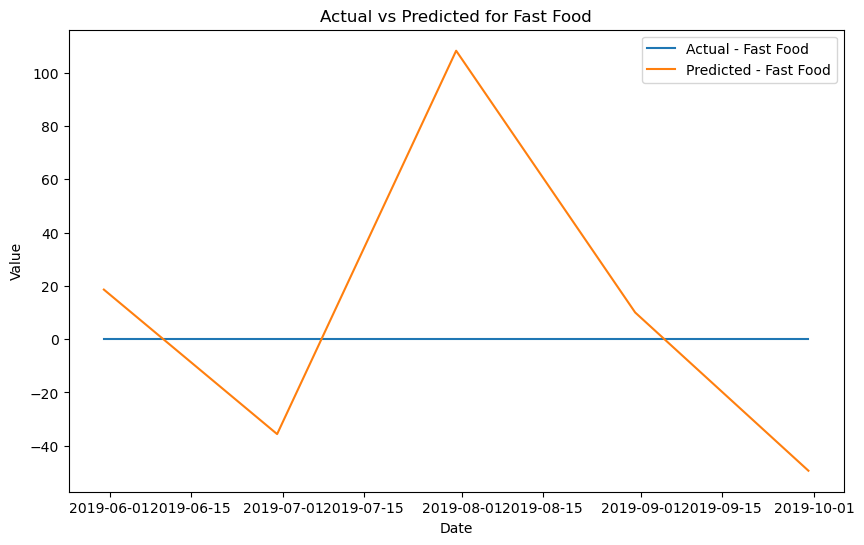

RMSE for Food & Dining: 50.00000596817458


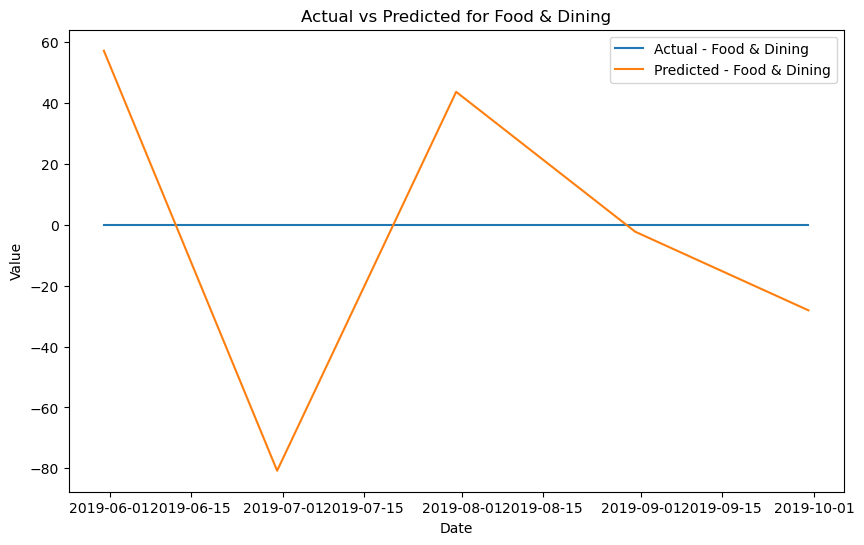

RMSE for Gas & Fuel: 112.72081387526589


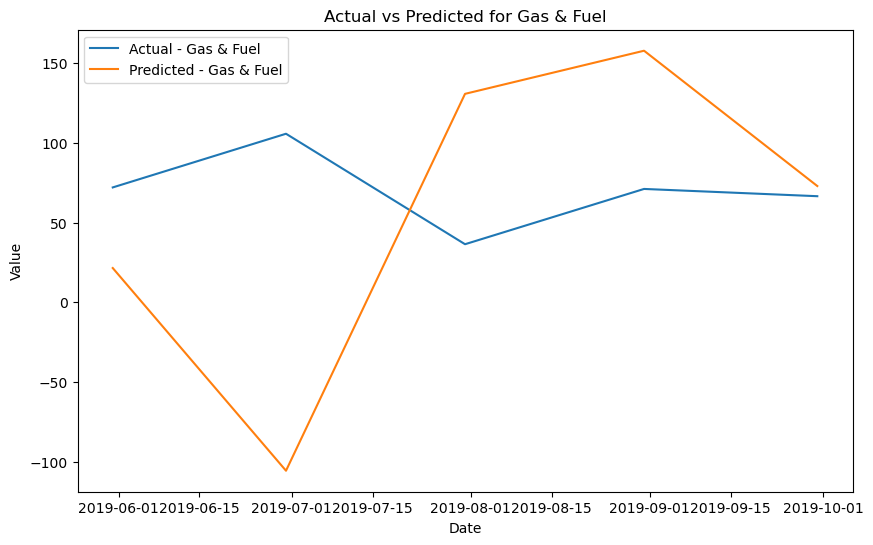

RMSE for Groceries: 257.1732789115861


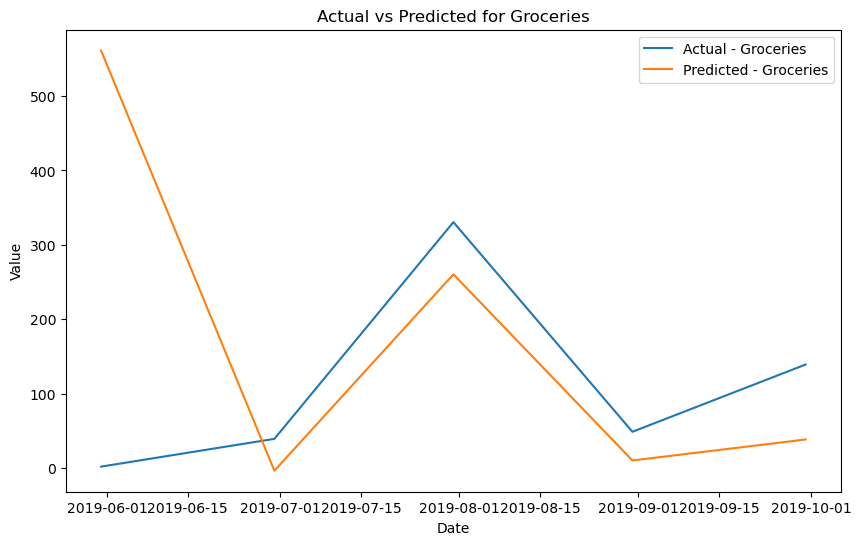

RMSE for Haircut: 47.92864342484789


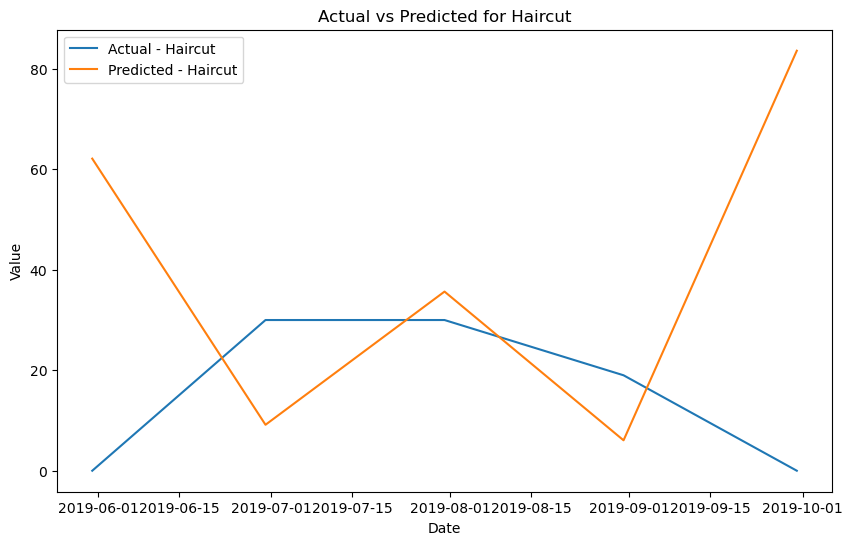

RMSE for Home Improvement: 5630.620535841903


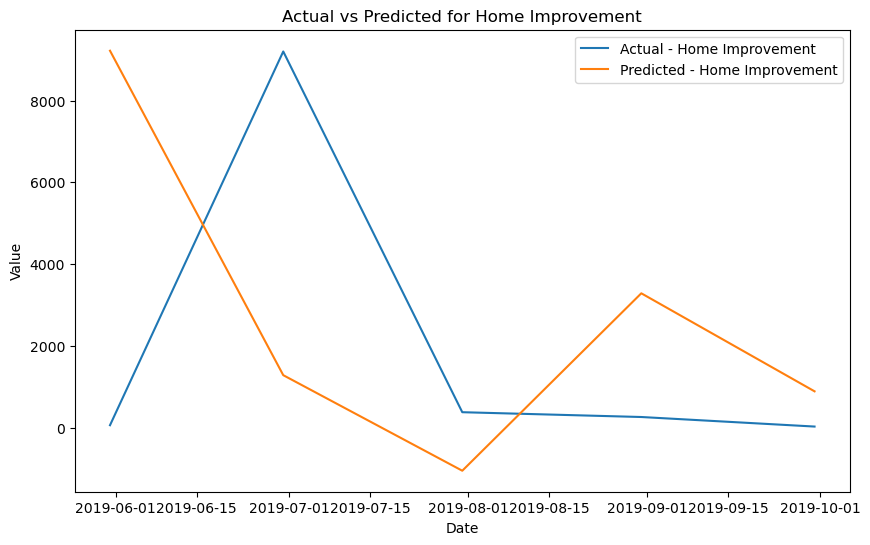

RMSE for Internet: 6.703154749845713


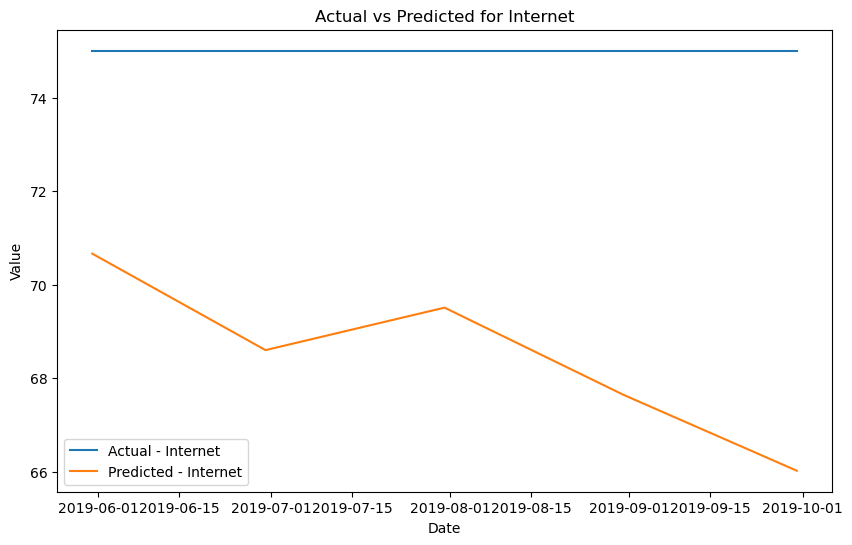

RMSE for Mobile Phone: 14.371716885032258


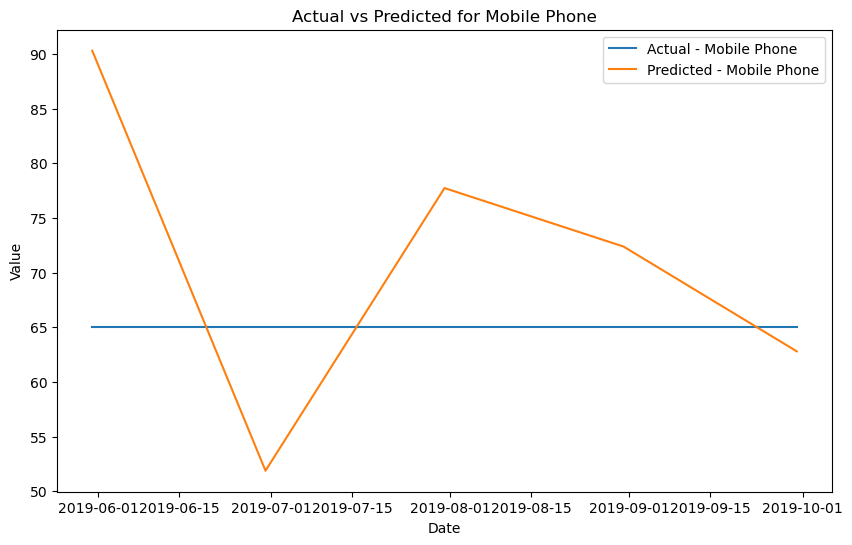

RMSE for Mortgage & Rent: 72.07947136986888


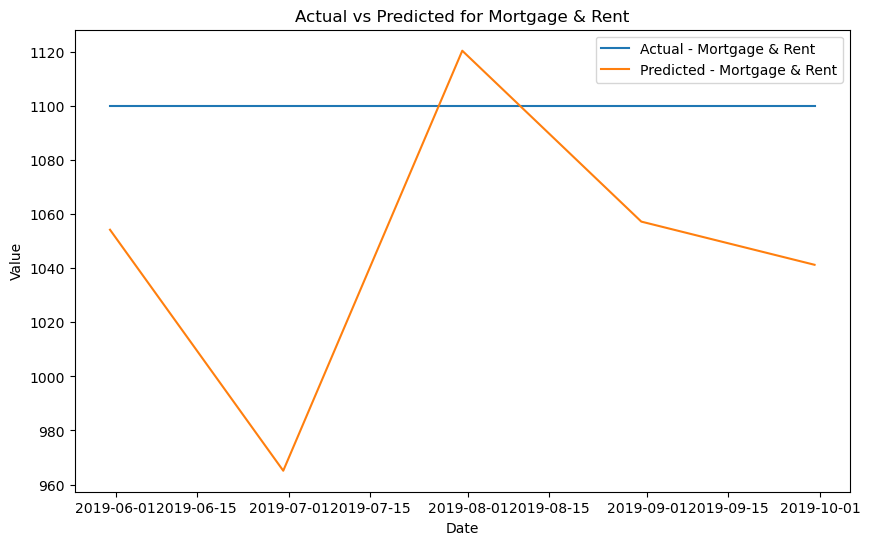

RMSE for Movies & DVDs: 21.71351368243108


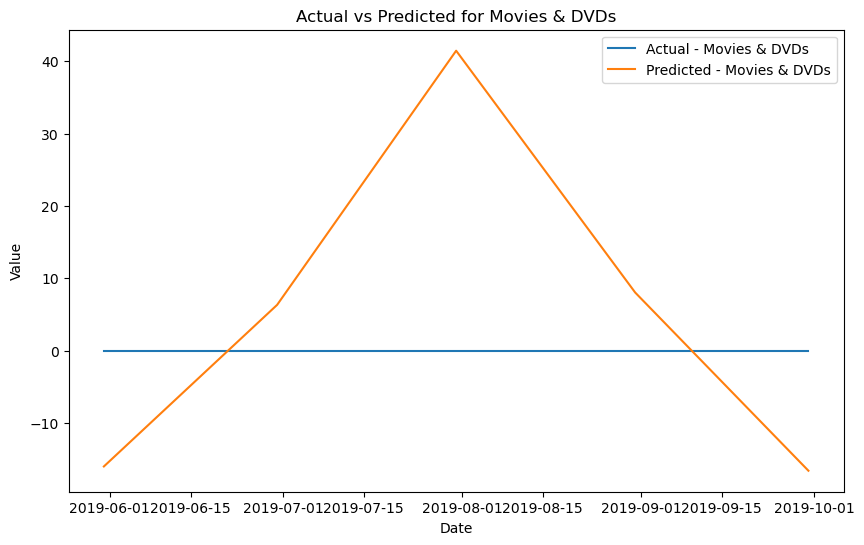

Music was a fixed amount with RMSE 0.0
RMSE for Paycheck: 1635.0394304832053


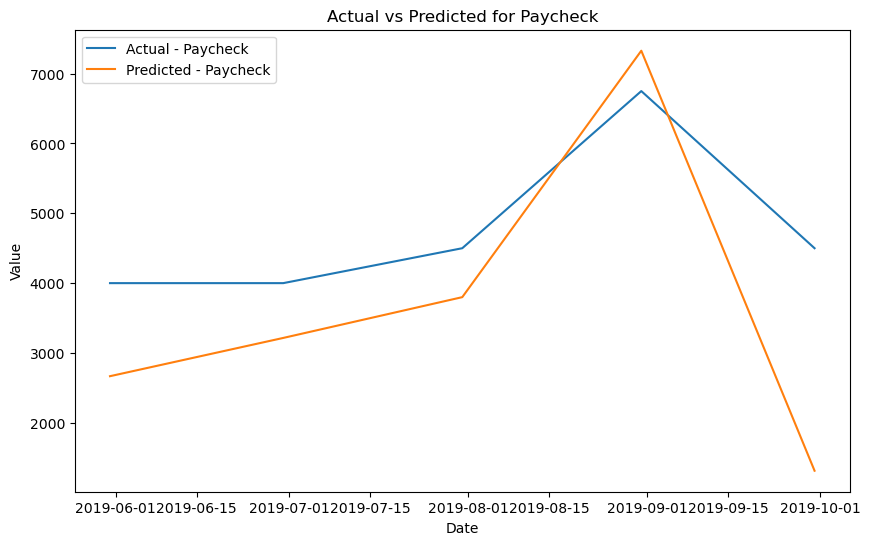

RMSE for Restaurants: 92.44072019475009


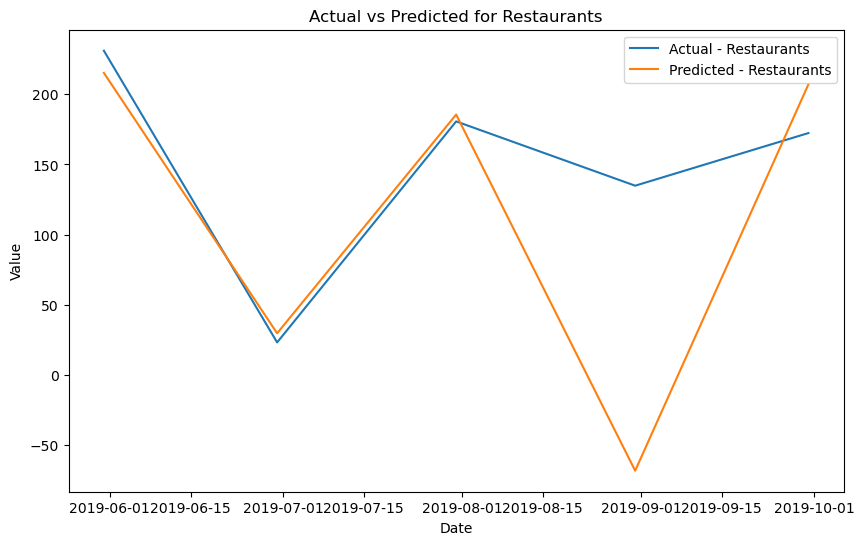

RMSE for Shopping: 149.74003567782563


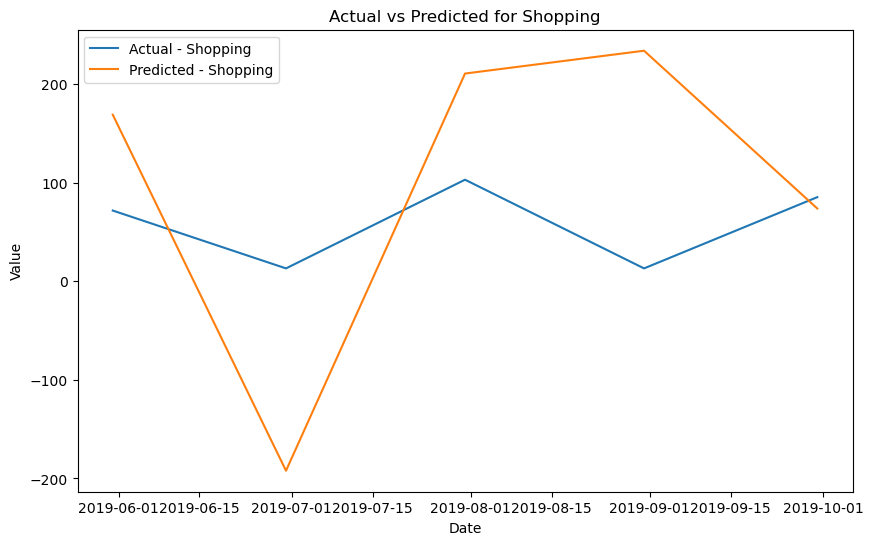

RMSE for Television: 8.465891098527104


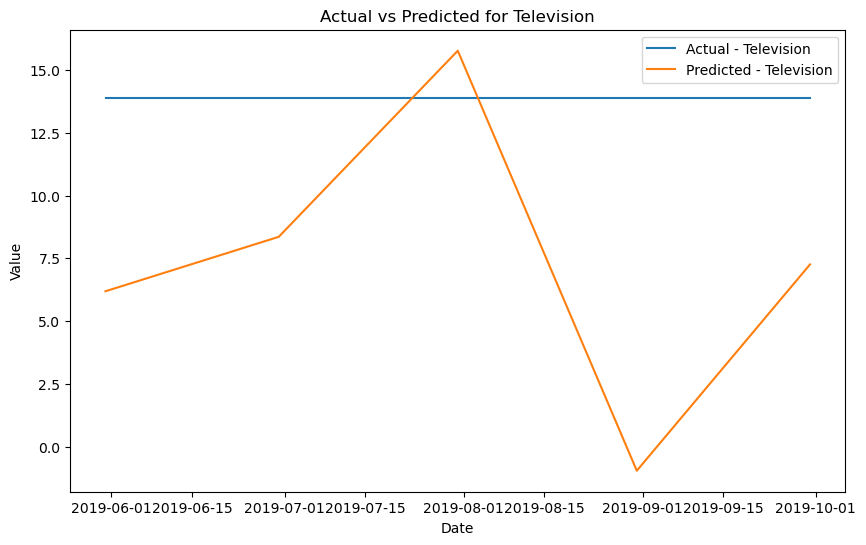

RMSE for Utilities: 15.939125104940416


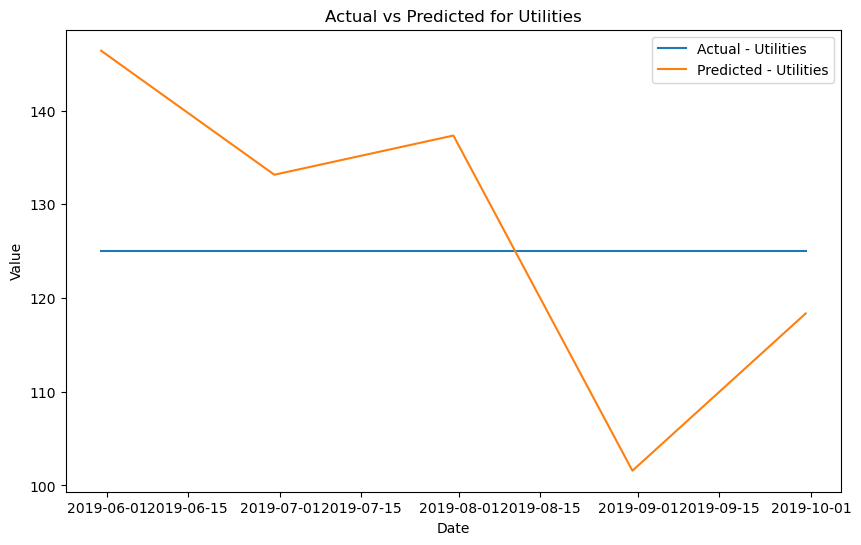

Average RMSE across all categories: 491.9224721733502


In [106]:
# Make Predictions and Evaluate the model

predictions_t = model_fit.forecast(test_t_fil.values, steps=5)
predictions = pd.DataFrame(predictions_t, columns=test_t_fil.columns, index=test_t_fil.index[-5:])

'''
# now re-add constant columns
for old_col in constant_columns:
    predictions[old_col] = train_t[old_col]
    test_t[old_col] = train_t[old_col]
'''

rmse_values = {}
num_zeros = 0
for category in monthly_train_data.index:

    if category in predictions.T.index:
        
        test_vals = test_t[category]
        pred_vals = predictions[category]
    
        rmse = sqrt(mean_squared_error(test_vals, pred_vals))
        rmse_values[category] = rmse
        print(f'RMSE for {category}: {rmse}')
    
        # Plot actual vs prediction for each category
        plt.figure(figsize=(10, 6))
        plt.plot(test_vals.index, test_vals, label=f'Actual - {category}')
        plt.plot(test_vals.index, pred_vals, label=f'Predicted - {category}')
        plt.title(f'Actual vs Predicted for {category}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    else:
        print(f"{category} was a fixed amount with RMSE 0.0")
        num_zeros += 1


# Average RMSE across all categories
average_rmse = sum(rmse_values.values()) / len(rmse_values) + num_zeros
print(f'Average RMSE across all categories: {average_rmse}')

In [109]:
# WILL USE ARIMA INSTEAD

category_model_dict

[['Alcohol & Bars', <statsmodels.tsa.arima.model.ARIMA at 0x14de2d850>],
 ['Auto Insurance', <statsmodels.tsa.arima.model.ARIMA at 0x1696c59d0>],
 ['Coffee Shops', <statsmodels.tsa.arima.model.ARIMA at 0x14dafa8d0>],
 ['Credit Card Payment', <statsmodels.tsa.arima.model.ARIMA at 0x168c27210>],
 ['Electronics & Software',
 ['Entertainment', <statsmodels.tsa.arima.model.ARIMA at 0x14d6ddad0>],
 ['Fast Food', <statsmodels.tsa.arima.model.ARIMA at 0x1691a04d0>],
 ['Food & Dining', <statsmodels.tsa.arima.model.ARIMA at 0x1695cf1d0>],
 ['Gas & Fuel', <statsmodels.tsa.arima.model.ARIMA at 0x1692f21d0>],
 ['Groceries', <statsmodels.tsa.arima.model.ARIMA at 0x16907b4d0>],
 ['Haircut', <statsmodels.tsa.arima.model.ARIMA at 0x14da833d0>],
 ['Home Improvement', <statsmodels.tsa.arima.model.ARIMA at 0x168bd1550>],
 ['Internet', <statsmodels.tsa.arima.model.ARIMA at 0x1690a2f90>],
 ['Mobile Phone', <statsmodels.tsa.arima.model.ARIMA at 0x169034710>],
 ['Mortgage & Rent', <statsmodels.tsa.arima.model

In [130]:
# forecast for next month

final_predictions = []

date_wanted = "2019-10-31"
for pair in category_model_dict:
    model_fit = pair[1].fit()
    forecast = model_fit.get_forecast(steps=date_wanted)
    forecast_vals = forecast.predicted_mean
    print(f"{pair[0]} will be {forecast_vals[-1]}")
    final_predictions.append([pair[0], forecast_vals[-1]])

/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{pair[0]} will be {forecast_vals[-1]}")
/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_predictions.append([pair[0], forecast_vals[-1]])
/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

Alcohol & Bars will be 33.66586296654688
Auto Insurance will be 75.0
Coffee Shops will be 4.641419545898046
Credit Card Payment will be 1847.741952275202
Electronics & Software will be 136.4638531065055
Entertainment will be -3.576245161103093e-30
Fast Food will be 42.40691587409889
Food & Dining will be 12.251215535761677
Gas & Fuel will be 70.00951176886291
Groceries will be 159.59463621595447
Haircut will be 19.318248742286254
Home Improvement will be 35.57106664550227
Internet will be 75.00559193380653
Mobile Phone will be 65.44530937577115
Mortgage & Rent will be 1100.0125927489012
Movies & DVDs will be 0.06211259073025282
Music will be 10.69
Paycheck will be 4491.402700693033
Restaurants will be 41.902507208981994
Shopping will be 72.98056004644613
Television will be 11.760132470520304
Utilities will be 132.6356600792659


/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{pair[0]} will be {forecast_vals[-1]}")
/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_predictions.append([pair[0], forecast_vals[-1]])
/var/folders/8r/rmwy73rs4tz9jxhpmymx8lkr0000gn/T/ipykernel_68608/1963452355.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

In [131]:
final_predictions

[['Alcohol & Bars', 33.66586296654688],
 ['Auto Insurance', 75.0],
 ['Coffee Shops', 4.641419545898046],
 ['Credit Card Payment', 1847.741952275202],
 ['Electronics & Software', 136.4638531065055],
 ['Entertainment', -3.576245161103093e-30],
 ['Fast Food', 42.40691587409889],
 ['Food & Dining', 12.251215535761677],
 ['Gas & Fuel', 70.00951176886291],
 ['Groceries', 159.59463621595447],
 ['Haircut', 19.318248742286254],
 ['Home Improvement', 35.57106664550227],
 ['Internet', 75.00559193380653],
 ['Mobile Phone', 65.44530937577115],
 ['Mortgage & Rent', 1100.0125927489012],
 ['Movies & DVDs', 0.06211259073025282],
 ['Music', 10.69],
 ['Paycheck', 4491.402700693033],
 ['Restaurants', 41.902507208981994],
 ['Shopping', 72.98056004644613],
 ['Television', 11.760132470520304],
 ['Utilities', 132.6356600792659]]